<a href="https://colab.research.google.com/github/nkumarcc/tf-attention-is-all-you-need/blob/main/Attention_is_All_You_Need_Take_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from platform import python_version
python_version()

'3.10.12'

In [2]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

2023-07-12 02:35:25.009801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 02:35:26.681560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 63.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
2023-07-12 02:35:43.112984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 02:35:44.488582: W tensorflow/compiler/tf2tensorrt/utils/p

In [4]:
!pip install portalocker

In [5]:
!pip install --upgrade torchtext

# 1. Need to import data

In [3]:
from torchtext.datasets import IWSLT2017

# Set the source and target language
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Get the training, validation and test data
train_iter, val_iter, test_iter = IWSLT2017(split=('train', 'valid', 'test'), language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [10]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Define the tokenizers
token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# Define function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define the special tokens
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Building vocab
vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = IWSLT2017(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

HTTPError: ignored

# 2. Build the model

**Scaled Dot Product Attention:**

"""
Inputs:
- Q - n x d_k
- K - n x d_k
- V - n x d_v
- mask: Whether or not to mask earlier values (for the output decoder)

Outputs:
- X - n x d_v
"""

**Multi-Head Attention:**

"""
Params:
- num_heads = Number of parallel layers (h in the paper)
- d_model = d_v * h. We're in general setting d_v and d_k equal in the paper/implementation
- d_k = dim of queries/keys
- d_v = dim of values

Inputs:
- Q - n x d_k
- K - n x d_k
- V - n x d_v
- mask: Whether or not to mask earlier values (for the output decoder)

Outputs:
- Z - n x d_v
"""

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model=512):
        super(PositionalEmbedding, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

    def forward(self, X):
        X = self.token_embedding(X)
        return self.positional_encoding(X)

class FeedForward(nn.Module):
    def __init__(self, d_model=512, d_ff=2048):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, X):
        X = self.linear_1(X)
        X = F.relu(X)
        return self.linear_2(X)

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, mask=False):
        Z = torch.mm(Q, K.transpose(-2, -1)) / math.sqrt(K.size(-1))
        if mask:
          mask = torch.tril(torch.ones(Z.shape)).bool().to(Z.device)
          Z = Z.masked_fill(~mask, float('-inf'))
        Z = F.softmax(Z, dim=-1)
        return torch.matmul(Z, V)

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads=8, d_model=512, d_data=64):
        super(MultiHeadAttention, self).__init__()
        self.Q_linears = nn.ModuleList([nn.Linear(d_model, d_data) for _ in range(num_heads)])
        self.K_linears = nn.ModuleList([nn.Linear(d_model, d_data) for _ in range(num_heads)])
        self.V_linears = nn.ModuleList([nn.Linear(d_model, d_data) for _ in range(num_heads)])
        self.attention_layers = nn.ModuleList([ScaledDotProductAttention() for _ in range(num_heads)])
        self.output_linear = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=False):
        head_outputs = [
            attention_layer(Q_linear(Q), K_linear(K), V_linear(V), mask)
            for Q_linear, K_linear, V_linear, attention_layer in
            zip(self.Q_linears, self.K_linears, self.V_linears, self.attention_layers)
        ]
        Z = torch.cat(head_outputs, dim=-1)
        return self.output_linear(Z)

class Encoder(nn.Module):
    def __init__(self, num_heads=8, d_model=512, d_data=64):
        super(Encoder, self).__init__()
        self.mha = MultiHeadAttention(num_heads, d_model, d_data)
        self.add_norm_mha = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_model * 4)
        self.add_norm_feed_forward = nn.LayerNorm(d_model)

    def forward(self, X):
        X_mha = self.mha(X, X, X)
        X_mha = self.add_norm_mha(X_mha + X)
        Z = self.feed_forward(X_mha)
        Z = self.add_norm_feed_forward(X_mha + Z)
        return Z

class Decoder(nn.Module):
    def __init__(self, num_heads=8, d_model=512, d_data=64):
        super(Decoder, self).__init__()
        self.masked_mha = MultiHeadAttention(num_heads, d_model, d_data)
        self.add_norm_masked_mha = nn.LayerNorm(d_model)
        self.combined_mha = MultiHeadAttention(num_heads, d_model, d_data)
        self.add_norm_combined_mha = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_model * 4)
        self.add_norm_feed_forward = nn.LayerNorm(d_model)

    def forward(self, X, Z_input):
        X_masked_mha = self.masked_mha(X, X, X, True)
        X_masked_mha = self.add_norm_masked_mha(X_masked_mha + X)
        Z_mha = self.combined_mha(Z_input, Z_input, X_masked_mha)
        Z_mha = self.add_norm_combined_mha(Z_mha + X_masked_mha)
        Z = self.feed_forward(Z_mha)
        Z = self.add_norm_feed_forward(Z_mha + Z)
        return Z

class Transformer(nn.Module):
    def __init__(self, vocab_size, num_layers=6, num_heads=8, d_data=64):
        super(Transformer, self).__init__()
        d_model = num_heads * d_data
        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.encoders = nn.ModuleList([Encoder(num_heads, d_model, d_data) for _ in range(num_layers)])
        self.decoders = nn.ModuleList([Decoder(num_heads, d_model, d_data) for _ in range(num_layers)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, X, Y):
        X = self.positional_embedding(X)
        for encoder in self.encoders:
          X = encoder(X)

        Y = self.positional_embedding(Y)
        for decoder in self.decoders:
          Y = decoder(Y, X)

        Y = self.linear(Y)
        return F.log_softmax(Y, dim=-1)

# 3. Test components

In [3]:
# Positional Encoding

import numpy as np
import matplotlib.pyplot as plt

test_positional_matrix = torch.ones(1, 2048, 512)
positional_encoding_layer = PositionalEncoding(512)
encoded = positional_encoding_layer(test_positional_matrix)

print(encoded.shape)

torch.Size([1, 2048, 512])


In [4]:
encoded[0]

tensor([[1.1111, 2.2222, 0.0000,  ..., 2.2222, 0.0000, 2.2222],
        [1.1111, 2.2222, 1.1111,  ..., 2.2222, 1.1111, 2.2222],
        [0.0000, 2.2222, 1.1111,  ..., 0.0000, 1.1111, 2.2222],
        ...,
        [1.1111, 2.2222, 1.1111,  ..., 2.2222, 1.1111, 2.2222],
        [1.1111, 0.0000, 1.1111,  ..., 2.2222, 1.1111, 0.0000],
        [1.1111, 2.2222, 1.1111,  ..., 2.2222, 1.1111, 2.2222]])

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


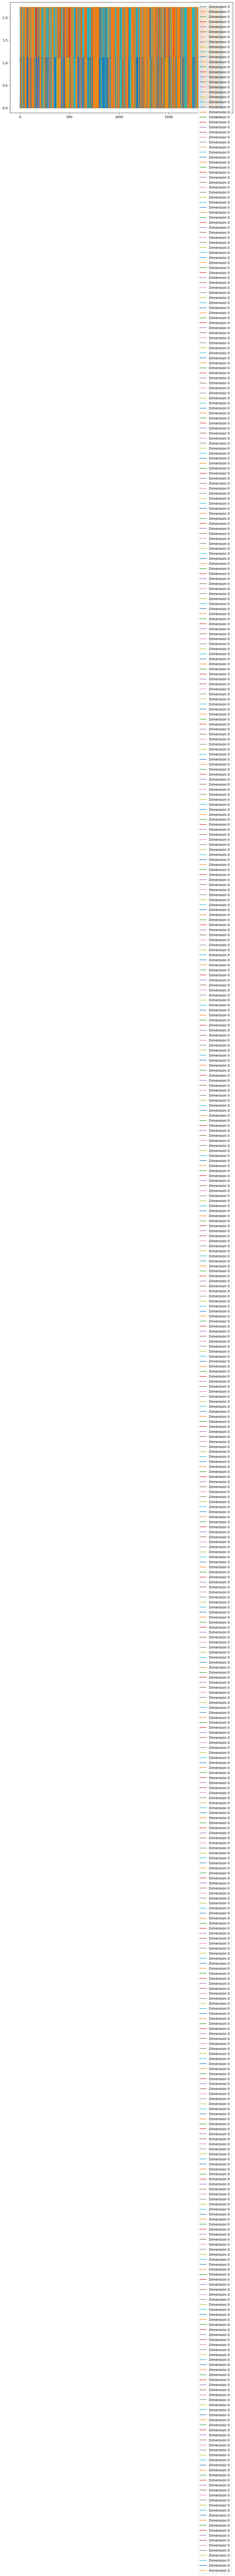

In [9]:
# encoded = encoded[0].detach().numpy()

# Plot the output for some dimensions
plt.figure(figsize=(12, 6))
plt.plot(encoded, label=f"Dimension")
# for i in range(1):  # Change this number to plot more or fewer dimensions
#     plt.plot(encoded[:, i], label=f"Dimension {i}")
plt.legend()
plt.show()